In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os

model_name = "model-tk45el88"

if not os.path.isdir(model_name):
    api = wandb.Api()
    artifact = api.artifact(f"fdlx/sdofm/{model_name}:best", type="model")
    artifact.download(model_name)

wandb: Downloading large artifact model-tk45el88:best, 530.78MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.7


'model-tk45el88'

In [3]:
from sdofm.pretraining import MAE
from pathlib import Path

model = MAE.load_from_checkpoint(Path(model_name) / "model.ckpt")

/opt/conda/envs/sdofm/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.1


In [11]:
model = MAE.load_from_checkpoint("../mae128-epoch=17-step=139302.ckpt")

/opt/conda/envs/sdofm/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.1


In [13]:
import omegaconf
from sdofm.datasets import SDOMLDataModule
import os

cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae_tpu_sweep.yaml")

data_module = SDOMLDataModule(
    # hmi_path=os.path.join(
    #     cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=5,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [14]:
data = next(iter(data_module.valid_ds))

In [6]:
import torch

In [15]:
loss, x_hat, mask = model(torch.Tensor([data]))

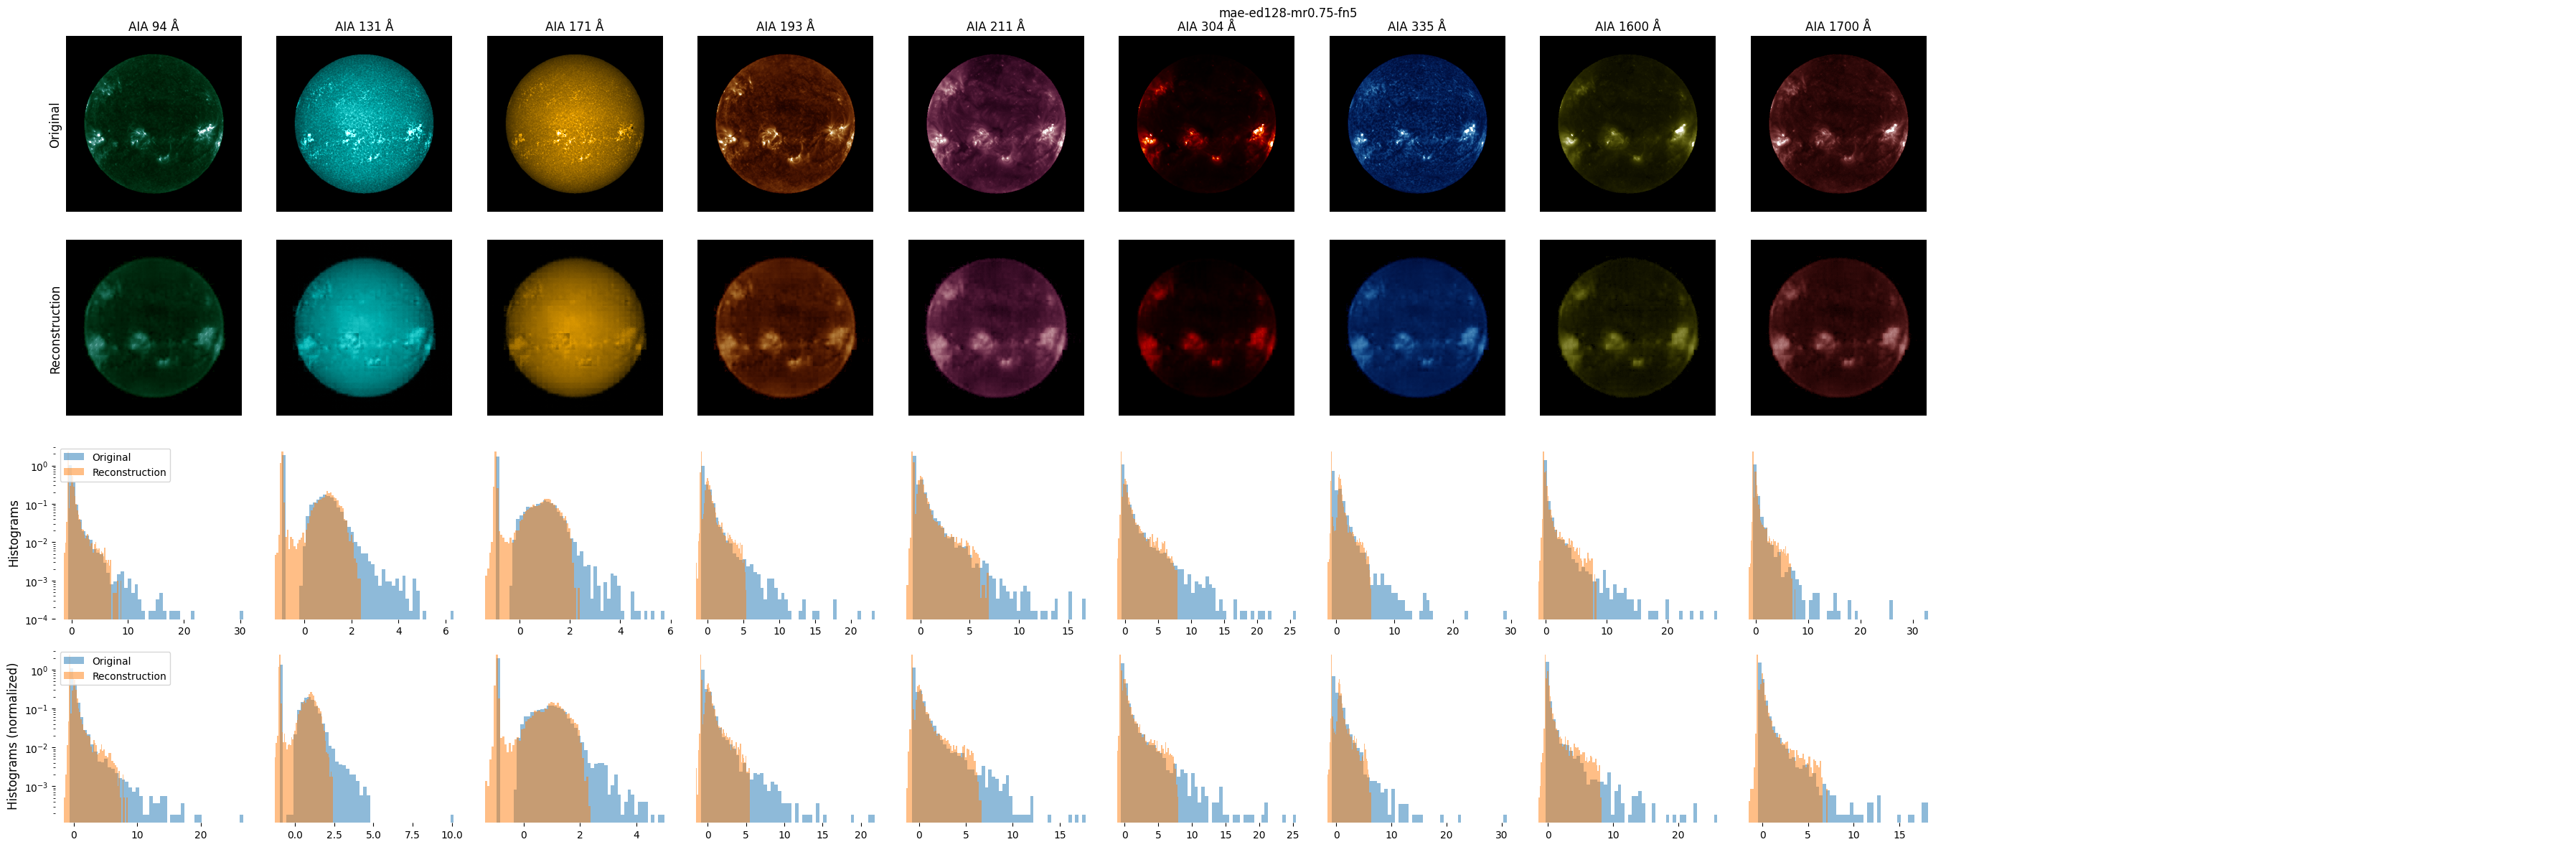

In [16]:
from sdofm.visualisation.sdo import sdo_reconstruction_plot

sdo_reconstruction_plot(
    torch.Tensor(data[:, 0, :, :]), x_hat[0, :, 0, :, :], title="mae-ed128-mr0.75-fn5"
)

Text(0.5, 1.0, '75% masked (yellow=mask)')

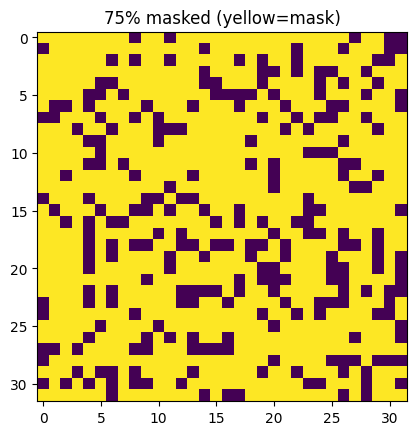

In [21]:
import matplotlib.pyplot as plt

plt.imshow(mask.reshape((32, 32, 5))[:, :, 0])
plt.title("75% masked (yellow=mask)")

In [10]:
512 / 16

32.0